In [91]:
%load_ext autoreload
%autoreload 2

import os,sys,inspect
# current_dir = '/home/jiayuand/seqOED_variational/examples/location'
# parent_dir = '/home/jiayuand/seqOED_variational'

# current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
# parent_dir = os.path.dirname(os.path.dirname(current_dir))
parent_dir = '/scratch/xhuan_root/xhuan1/wgshen/vsOED/'
sys.path.insert(0, parent_dir) 

import numpy as np
# from scipy.stats import norm, beta, dirichlet
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from   torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = torch.device(dev) 
torch.set_default_device(device)
dtype = torch.float32
torch.set_default_dtype(dtype)

# from vsOED import VSOED, PGvsOED, GMM_NET, NFs, POST_APPROX
# from vsOED.utils import *
# from vsOED.models import *

from vsOED_multimodel import VSOED, PGvsOED
from vsOED_multimodel.utils import *

import dowel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
class SOURCE(object):
    def __init__(self, **kws):
        pass
    
    def deterministic(self, theta, d, xp=None):
        base_signal = 0.1
        max_signal  = 1e-4

        # m = theta[:, 0:1]
        theta1 = theta[:, 0:1]
        theta2 = theta[:, 1:2]
        theta3 = theta[:, 2:3]
        theta4 = theta[:, 3:4]
        # theta5 = theta[:, 5:6]
        # theta6 = theta[:, 6:7]

        d1     = d[:, 0:1]
        d2     = d[:, 1:2]
        G      = (base_signal 
                  + 1/( (theta1-d1)**2 + (theta2-d2)**2 + max_signal) 
                  + ( 1/( (theta3-d1)**2 + (theta4-d2)**2 + max_signal ) ) )

        return torch.log(G), torch.tensor(0.5)
        
    def model(self, stage, theta, d,  xp=None):
        try:
            theta = torch.from_numpy(theta).to(device)
            d = torch.from_numpy(d).to(device)
        except:
            pass
        with torch.no_grad():
            mu_eta, sigma_eta = self.deterministic(theta, d, xp)
            eta = np.random.normal(mu_eta.cpu().numpy(), sigma_eta.cpu().numpy())

        return torch.from_numpy(eta).to(device, dtype).cpu().numpy()
    
    def loglikeli(self, stage, y, theta, d, xp=None, true_theta=None):
        """
        y : (n or 1, n_obs)
        theta : (n or 1, n_param)
        d : (n or 1, n_design)
        """
        with torch.no_grad():
            mu_eta, sigma_eta = self.deterministic(theta, d, xp)
            if len(y) == 1:
                y = y.expand((len(theta), -1))
            normal = torch.distributions.Normal(mu_eta, sigma_eta)
            log_prob = normal.log_prob(y)
            log_prob = log_prob.sum(-1)
        return log_prob.cpu().numpy()
    
    def logevid(self, *args, **kws):
        return math.log(1 / 3.0)
    
    def log_poi_prior(self, prior_samples):
        # m = prior_samples[:, 0]
        theta = prior_samples.reshape(-1, 2, 2)
        log_probs = norm_logpdf(theta, 0, 1)
        # log_prob = np.zeros(len(log_probs))
        # log_prob[m == 1] = log_probs[m == 1][:, 0]
        # log_prob[m == 2] = log_probs[m == 2][:, :2].sum(-1)
        # log_prob[m == 3] = log_probs[m == 3].sum(-1)
        return log_probs.sum(-1)
    
    def rvs(self, n_sample):
        # m = np.random.randint(3, size=n_sample) + 1
        theta = np.random.randn(n_sample, 4)
        # theta[m < 3, -2:] = 0
        # theta[m < 2, -4:] = 0
        # theta = np.c_[m.reshape(-1, 1), theta]
        return torch.from_numpy(theta).to(device, dtype).cpu().numpy()

In [93]:
class GMM_net(nn.Module):
    def __init__(self, n_d, n_y, n_theta, n_mixture, activate=None):
        super().__init__()
        self.n_d = n_d
        self.n_y = n_y
        self.n_theta = n_theta
        self.n_mixture = n_mixture
        activate = activate
        feature_dimns = [n_d + n_y, 256, 256]
        weight_dimns = [256, 256, 256, n_mixture + 1]
        mu_dimns = [256, 256, 256, n_mixture * n_theta]
        sigma_dimns = [256, 256, 256, n_mixture * n_theta]
        feature_layers = []
        weight_layers = []
        mu_layers = []
        sigma_layers = []
        for i in range(len(feature_dimns) - 1):
            feature_layers.append(nn.Linear(feature_dimns[i], feature_dimns[i + 1]))
#             feature_layers.append(nn.BatchNorm1d(feature_dimns[i + 1]))
            feature_layers.append(activate())
        for i in range(len(weight_dimns) - 1):
            weight_layers.append(nn.Linear(weight_dimns[i], weight_dimns[i + 1]))
            if i < len(weight_dimns) - 2:
#                 weight_layers.append(nn.BatchNorm1d(weight_dimns[i + 1]))
                weight_layers.append(activate())
        weight_layers.append(nn.Softmax(dim=1))
        for i in range(len(mu_dimns) - 1):
            mu_layers.append(nn.Linear(mu_dimns[i], mu_dimns[i + 1]))
            if i < len(mu_dimns) - 2:
#                 mu_layers.append(nn.BatchNorm1d(mu_dimns[i + 1]))
                mu_layers.append(activate())
        for i in range(len(sigma_dimns) - 1):
            sigma_layers.append(nn.Linear(sigma_dimns[i], sigma_dimns[i + 1]))
            if i < len(sigma_dimns) - 2:
#                 sigma_layers.append(nn.BatchNorm1d(sigma_dimns[i + 1]))
                sigma_layers.append(activate())
        self.feature_net = nn.Sequential(*feature_layers)
        self.weight_net = nn.Sequential(*weight_layers)
        self.mu_net = nn.Sequential(*mu_layers)
        self.sigma_net = nn.Sequential(*sigma_layers)
        self.param_bounds = torch.tensor([-20, 20]).reshape(-1, 2).to(device)

    def forward(self, x):
        thetas = x[:, self.n_d+self.n_y:self.n_d+self.n_y+self.n_theta] # (N, n_theta)
        thetas = thetas.reshape(-1, 1, self.n_theta)
        x = x[:, :self.n_d + self.n_y]
        features = self.feature_net(x)
        weights = self.weight_net(features) # (N, n_mixture)
        mus = self.mu_net(features) # (N, n_mixture*n_theta)
        mus = torch.sigmoid(mus)
        sigmas = self.sigma_net(features)

        sigmas = torch.sigmoid(sigmas)

        mus = mus.reshape(-1, self.n_mixture, self.n_theta) # (N, n_mixture, n_theta)

        mus   = mus * 12 - 6
        sigmas = sigmas.reshape(-1, self.n_mixture, self.n_theta) # (N, n_mixture, n_theta)
        # sigmas = sigmas * torch.tensor([3, 3, 3, 3]).to(device)
        sigmas = sigmas + 0.00001 
        # truncnorm = TruncatedNormal(mus[..., :3], sigmas[..., :3], 0, 1)
        normal = torch.distributions.Normal(mus, sigmas)
        # logprob_mixture_truncnorm = truncnorm.log_prob(thetas[..., :3])
        # logprob_mixture_normal = normal.log_prob(thetas[..., 3:4])
#         print(logprob_mixture_truncnorm.shape, logprob_mixture_normal.shape)
        # logprob_mixture = logprob_mixture_truncnorm.sum(-1) + logprob_mixture_normal.sum(-1)
        logprob_mixture = normal.log_prob(thetas).sum(-1)
        prob_mixture = torch.exp(logprob_mixture)
        
#         prob_mixture = 1 / np.sqrt(2*np.pi) / sigmas * torch.exp(-(thetas - mus)**2 / 2 / sigmas**2) # (N, n_mixture, n_theta)
#         prob_mixture = prob_mixture.prod(-1) # (N, n_mixture)
        probs = (prob_mixture * weights[:, :-1]).sum(-1) # (N)
        thetas = thetas.reshape(-1, self.n_theta) # (N, n_theta)
        in_bounds = ((thetas > self.param_bounds[:, 0]) * (thetas < self.param_bounds[:, 1])).prod(-1)
        uniform_probs = in_bounds / 40 ** 4
        probs = probs + uniform_probs * weights[:,-1]
        probs += 1e-27
        logprobs = torch.log(probs)
        return logprobs

In [94]:
class Post_approx(object):
    def __init__(self,  n_stage, n_d, n_y, n_thetas, n_mixture, activate=None, prior=None, evid_weight=1, post_weight=1, n_incre=1):
        evid_lr_initial = 1e-3
        post_lr_initial = 1e-3
        evid_scheduler_gamma = 0.9999
        post_scheduler_gamma = 0.9999
        assert evid_weight > 0 or post_weight > 0
        if activate is None:
            activate = nn.ReLU
        self.prior = prior
        
        if isinstance(n_thetas, int):
            n_thetas = [n_thetas]
        if len(n_thetas) == 1:
            evid_weight = 0
        self.n_thetas = n_thetas
        
        assert n_incre <= n_stage
        stages_incre = [int(n_stage * (i + 1) / n_incre) - 1 for i in range(n_incre)]
        print(stages_incre)
        
        if evid_weight > 0:
            self.evid_nets = {}
            self.evid_optimizer = {}
            self.evid_scheduler = {}
            for stage in stages_incre:
                evid_dimns = [(stage + 1) * (n_d + n_y), 256, 256, 256, len(self.n_thetas)]
                evid_layers = []
                for i in range(len(evid_dimns) - 1):
                    evid_layers.append(nn.Linear(evid_dimns[i], evid_dimns[i + 1]))
        #             feature_layers.append(nn.BatchNorm1d(feature_dimns[i + 1]))
                    evid_layers.append(activate())
                evid_layers.append(nn.LogSoftmax(dim=1))
                evid_net = nn.Sequential(*evid_layers).float().to(device)
                evid_optimizer = optim.Adam(evid_net.parameters(), lr=evid_lr_initial)
                evid_scheduler = torch.optim.lr_scheduler.ExponentialLR(self.evid_optimizer, gamma=evid_scheduler_gamma)
                self.evid_nets[stage] = evid_net
                self.evid_optimizers[stage] = evid_optimizer
                self.evid_schedulers[stage] = evid_scheduler
            
        self.post_nets = {}
        self.post_optimizers = {}
        self.post_schedulers = {}
        if post_weight > 0:
            for stage in stages_incre:
                self.post_nets[stage] = []
                self.post_optimizers[stage] = []
                self.post_schedulers[stage] = []
                for n_theta in n_thetas:
                    post_net = GMM_net((stage + 1) * n_d, (stage + 1) * n_y, n_theta, n_mixture, activate).float().to(device)
                    optimizer = optim.Adam(post_net.parameters(), lr=post_lr_initial)
                    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=post_scheduler_gamma)
                    self.post_nets[stage].append(post_net)
                    self.post_optimizers[stage].append(optimizer)
                    self.post_schedulers[stage].append(scheduler)
        self.evid_weight = evid_weight
        self.post_weight = post_weight
        self.stages_incre = stages_incre
        self.n_stage = n_stage
        self.n_d = n_d
        self.n_y = n_y
        self.n_thetas = n_thetas
                
    def logevid(self, stage, ds, ys):
        assert self.evid_weight > 0
        with torch.no_grad():
            X = torch.cat([ds.reshape(len(ds), -1), ys.reshape(len(ys), -1)], dim=-1)
            logevid = self.evid_net[stage](X)
        return logevid
                
    def logpdf(self, stage, ds, ys, thetas):
        assert self.post_weight > 0
        with torch.no_grad():
            if isinstance(ds, torch.Tensor):
                X = torch.cat([ds.reshape(len(ds), -1), ys.reshape(len(ys), -1)], dim=-1)
            else:
                X = np.c_[ds.reshape(len(ds), -1), ys.reshape(len(ys), -1)]
            if len(self.n_thetas) > 1:
                m = thetas[:, 0]
                thetas = thetas[:, 1:]
            else:
                m = np.ones(len(thetas))
            if isinstance(ds, torch.Tensor):
                X = torch.cat([X, thetas], dim=-1)
            else:
                X = np.c_[X, thetas]
                X = torch.from_numpy(X).to(device, dtype)
            logpdf = torch.zeros(len(X)) - np.inf
            for m_idx, n_theta in enumerate(self.n_thetas):
                idxs = m == (m_idx + 1)
                logpdf[idxs] = self.post_nets[stage][m_idx](X[idxs])          ##### When use GMM, only one output (logpdf)
            # logpdf[logpdf == -np.inf] = 0
            # logpdf[np.isnan(logpdf)] = 0
            return logpdf.cpu().numpy()
    
    def train(self, ds, ys, thetas, l, n_update=3):

        for stage in self.stages_incre:
            if isinstance(ds, torch.Tensor):
                X_evid = torch.cat([ds[:, :stage+1].reshape(len(ds), -1), ys[:, :stage+1].reshape(len(ys), -1)], dim=-1)
                if len(self.n_thetas) > 1:
                    X = torch.cat([X_evid, thetas[:, 1:]], dim=-1)
                else:
                    X = torch.cat([X_evid, thetas], dim=-1) 
            else:
                X_evid = np.c_[ds[:, :stage+1].reshape(len(ds), -1), ys[:, :stage+1].reshape(len(ys), -1)]
                if len(self.n_thetas) > 1:
                    X = np.c_[X_evid, thetas[:, 1:]]
                else:
                    X = np.c_[X_evid, thetas]
                X_evid = torch.from_numpy(X_evid).to(device, dtype)
                X = torch.from_numpy(X).to(device, dtype)
                
            for t in range(n_update):
                # train evid net
                if self.evid_weight > 0:
                    m = thetas[:, 0]
                    logevids = self.evid_nets[stage](X_evid)
                    logevids = logevids[torch.arange(len(logevids)).to(device), m - 1]
                    loss = torch.mean(-logevids)
                    self.evid_optimizers[stage].zero_grad()
                    loss.backward()
                    self.evid_optimizers[stage].step()
                if self.post_weight > 0:
                    if len(self.n_thetas) > 1:
                        m = thetas[:, 0]
                    else:
                        m = torch.ones(len(thetas))
                    logposts = torch.zeros(len(thetas)).to(device)
                    # logposts.requires_grad = True
                    for m_idx in range(len(self.n_thetas)):
                        idxs = m == (m_idx + 1)
                        idxs = idxs.to(device)
                        logposts[idxs] = self.post_nets[stage][m_idx](X[idxs])
                        # logposts = logposts[logposts > -np.inf]
                        # logposts = logposts[~torch.isnan(logposts)]
                    loss = torch.mean(-logposts)
                    for optimizer in self.post_optimizers[stage]:
                        optimizer.zero_grad()
                    loss.backward()  
                    for post_net in self.post_nets[stage]:
                        for param in post_net.parameters():
                            if torch.isnan(param.grad).any():
                                stop
                    for optimizer in self.post_optimizers[stage]:
                        optimizer.step()
            if self.evid_weight > 0:
                self.evid_schedulers[stage].step()
            if self.post_weight > 0:
                for scheduler in self.post_schedulers[stage]:
                    scheduler.step()
            if l % 1 == 0 and stage == self.stages_incre[-1]:
                if self.evid_weight > 0:
                    print('logevids', logevids.mean())
                if self.post_weight > 0:
                    print('logposts', logposts.mean())
        
    def reward_fun(self, stage, ds_hist, ys_hist, thetas):
        if stage == 0:
            if self.evid_weight > 0:
                if self.prior is None:
                    self.logevid_prior = 0
                else:
                    self.logevid_prior = self.prior.log_model_prior()
            if self.post_weight > 0:
                if self.prior is None:
                    self.logpdf_prior = 0
                else:
                    self.logpdf_prior = self.prior.log_poi_prior(thetas)
        if stage in self.stages_incre:
            if self.evid_weight > 0:
                m = thetas[:, 0].astype(int)
                logevid_post = self.logevid(stage, ds_hist, ys_hist)[np.arange(len(ds_hist)), m - 1]
                evid_kld = logevid_post - self.logevid_prior
                self.logevid_prior = logevid_post
            else:
                evid_kld = 0
            if self.post_weight > 0:
                logpdf_post = self.logpdf(stage, ds_hist, ys_hist, thetas)
                post_kld = logpdf_post - self.logpdf_prior
                self.logpdf_prior = logpdf_post
            else:
                post_kld = 0
            return (self.evid_weight * evid_kld + self.post_weight * post_kld)
        else:
            return 0
    
    def terminal_reward_fun(self, ds_hist, ys_hist, thetas):
        return 0
#         if self.evid_weight > 0:
#             m = thetas[:, 0].astype(int)
#             logevid_post = self.logevid(ds_hist, ys_hist)[np.arange(len(ds_hist)), m - 1]
#             if self.prior is None:
#                 logevid_prior = 0
#             else:
#                 logevid_prior = self.prior.logevid()
#             evid_kld = logevid_post - logevid_prior
#         else:
#             evid_kld = 0
            
#         if self.post_weight > 0:
#             m = thetas[:, 0]
#             logpdf_post = self.logpdf(ds_hist, ys_hist, thetas)
#             if self.prior is None:
#                 logpdf_prior = 0
#             else:
#                 logpdf_prior = self.prior.logpdf(thetas)
#             # print('logpdf_post: ', logpdf_post)
#             # print('logpdf_prior: ', logpdf_prior)
#             post_kld = logpdf_post - logpdf_prior
#         else:
#             post_kld = 0
            
#         return self.evid_weight * evid_kld + self.post_weight * post_kld
        
    def return_network(self, X):
        return self.post_net(X)

In [95]:
n_stage      = 10       # Number of stages.
n_design     = 2        # Number of design variables.
n_obs        = 1        # Number of observations.
n_pois       = [4]        # Number of parameters.
n_nuisps     = None
n_goals      = None
model_weight = 0
poi_weight   = 1
goal_weight  = 0

def set_random_seed(random_state=None):
    NoneType = type(None)
    assert isinstance(random_state, (int, NoneType)), (
           "random_state should be an integer or None.")
    if random_state is not None:
        np.random.seed(random_state)
        torch.manual_seed(random_state)
random_state  = 56789
set_random_seed(random_state)

model = SOURCE(multimodel=False, include_nuisance=False, include_goal=False)
prior = model

mu_bounds = {}
mu_bounds['poi'] = []
for n_poi in n_pois:
    mu_bounds['poi'].append([[-6, 6]] * n_poi)
if n_goals is not None:
    mu_bounds['goal'] = []
    for n_goal in n_goals:
        mu_bounds['goal'].append([[0, 3]] * n_goal)
max_sigmas = {}
max_sigmas['poi'] = []
for n_poi in n_pois:
    max_sigmas['poi'].append([1.0] * n_poi)
if n_goals is not None:
    max_sigmas['goal'] = []
    for n_goal in n_goals:
        max_sigmas['goal'].append([1.0] * n_goal)
truncnorm_info = {}
truncnorm_info['poi'] = [None] * len(n_pois)
if n_goals is not None:
    truncnorm_info['goal'] = []
    for n_goal in n_goals:
        info = []
        for i in range(n_goal):
            info.append([i, 0, 4])
            
n_incre = 1
share_interm_net = False

candidate_lrs = [[1e-3] * n_incre, [1e-4] * (n_incre - 1) + [1e-3]]
candidate_gammas = [[0.9999] * n_incre, [0.999999] * (n_incre - 1) + [0.9999]]
model_post_lrs = candidate_lrs[share_interm_net]
model_post_lr_scheduler_gammas = candidate_gammas[share_interm_net]
poi_post_lrs = candidate_lrs[share_interm_net]
poi_post_lr_scheduler_gammas = candidate_gammas[share_interm_net]
goal_post_lrs = candidate_lrs[share_interm_net]
goal_post_lr_scheduler_gammas = candidate_gammas[share_interm_net]

use_NFs = False
n_mixture = 8
activate = nn.ReLU

log_every = 100
folder = parent_dir + f'experiments/source_{len(n_pois)}model_{n_stage}stage_GMM/'
try:
    os.remove(folder + 'progress.csv')
except:
    pass
try:
    os.remove(folder + 'progress.txt')
except:
    pass
try:
    dowel.logger.remove_all()
except:
    pass
dowel.logger.add_output(dowel.StdOutput())
dowel.logger.add_output(dowel.CsvOutput(folder + 'progress.csv'))
dowel.logger.add_output(dowel.TextOutput(folder + 'progress.txt'))

try:
    for _ in range(100):
        dowel.logger.pop_prefix()
except:
    pass
dowel.logger.push_prefix('[SOURCE] ')
dowel.logger.log('Stored at ' + folder)
dowel.logger.log('Random seed:  ' + str(random_state))
dowel.logger.log('Device: ' + str(device))
dowel.logger.log('dtype: ' + str(dtype))

post_approx_params = {
    'n_stage': n_stage, 
    'n_design': n_design, 
    'n_obs': n_obs, 
    'n_pois': n_pois,
    'n_nuisps': n_nuisps,
    'n_goals': n_goals,
    'model_weight': model_weight,
    'poi_weight': poi_weight,
    'goal_weight': goal_weight,
    'mu_bounds': mu_bounds,
    'max_sigmas': max_sigmas,
    'truncnorm_info': truncnorm_info,
    'n_mixture': n_mixture,
    'activate': activate,
    'prior': prior,
    'n_incre': n_incre,
    'share_interm_net': share_interm_net,
    'model_post_lrs': model_post_lrs,
    'model_post_lr_scheduler_gammas': model_post_lr_scheduler_gammas,
    'poi_post_lrs': poi_post_lrs,
    'poi_post_lr_scheduler_gammas': poi_post_lr_scheduler_gammas,
    'goal_post_lrs': goal_post_lrs,
    'goal_post_lr_scheduler_gammas': goal_post_lr_scheduler_gammas,
    'use_NFs': use_NFs,
    'log_every': log_every,
    'dowel': dowel}

dowel.logger.log('Post_approx_params: ' + str(post_approx_params))

dowel.logger.dump_all()
# dowel.logger.remove_all()

# post_approx = POST_APPROX(**post_approx_params)
post_approx = Post_approx(n_stage, n_design, n_obs, n_pois, 8, activate, prior, evid_weight=0, post_weight=1, n_incre=1)
dowel.logger.dump_all()

2023-05-01 12:07:48 | [SOURCE] Stored at /scratch/xhuan_root/xhuan1/wgshen/vsOED/experiments/source_1model_10stage_GMM/
2023-05-01 12:07:48 | [SOURCE] Random seed:  56789
2023-05-01 12:07:48 | [SOURCE] Device: cuda:0
2023-05-01 12:07:48 | [SOURCE] dtype: torch.float32
2023-05-01 12:07:48 | [SOURCE] Post_approx_params: {'n_stage': 10, 'n_design': 2, 'n_obs': 1, 'n_pois': [4], 'n_nuisps': None, 'n_goals': None, 'model_weight': 0, 'poi_weight': 1, 'goal_weight': 0, 'mu_bounds': {'poi': [[[-6, 6], [-6, 6], [-6, 6], [-6, 6]]]}, 'max_sigmas': {'poi': [[1.0, 1.0, 1.0, 1.0]]}, 'truncnorm_info': {'poi': [None]}, 'n_mixture': 8, 'activate': <class 'torch.nn.modules.activation.ReLU'>, 'prior': <__main__.SOURCE object at 0x151e910f7160>, 'n_incre': 1, 'share_interm_net': False, 'model_post_lrs': [0.001], 'model_post_lr_scheduler_gammas': [0.9999], 'poi_post_lrs': [0.001], 'poi_post_lr_scheduler_gammas': [0.9999], 'goal_post_lrs': [0.001], 'goal_post_lr_scheduler_gammas': [0.9999], 'use_NFs': False

In [96]:
n_param = len(n_pois) > 1
try:
    n_param += max(n_pois)
except:
    pass
try:
    n_param += max(n_nuisps)
except:
    pass
try:
    n_param += max(n_goals)
except:
    pass

design_bounds = [(-4, 4), (-4, 4)] # lower and upper bounds of design variables.
def reward_fun(*args, **kws):
    return 0
nkld_reward_fun = reward_fun
kld_reward_fun = post_approx.reward_fun
phys_state_info = None
post_approx = post_approx
encoder_dimns = None
backend_dimns = None
actor_dimns = [256, 256, 256]
critic_dimns = [256, 256, 256]

vsoed_params = {
    'n_stage': n_stage,
    'n_param': n_param,
    'n_design': n_design,
    'n_obs': n_obs,
    'model': model,
    'prior': prior,
    'design_bounds': design_bounds,
    'nkld_reward_fun': nkld_reward_fun,
    'kld_reward_fun': kld_reward_fun,
    'phys_state_info': phys_state_info,
    'post_approx': post_approx,
    'encoder_dimns': encoder_dimns,
    'backend_dimns': backend_dimns,
    'actor_dimns': actor_dimns,
    'critic_dimns': critic_dimns,
    'activate': activate
}
dowel.logger.log('vsoed_params: ' + str(vsoed_params))

# vsoed = PGvsOED(**vsoed_params)



# Noise if following N(noise_loc, noise_base_scale + noise_ratio_scale * abs(G))
noise_loc         = 0
noise_base_scale  = 0
noise_ratio_scale = 0
noise_info        = [(noise_loc, noise_base_scale, noise_ratio_scale),]
set_random_seed(random_state)
vsoed = PGvsOED(model=model,     
               n_stage=n_stage,             
               n_param=n_param,                
               n_design=n_design,              
               n_obs=n_obs,                   
               prior=prior,
               design_bounds=design_bounds,
               noise_info=noise_info,
               stage_reward_fun=post_approx.reward_fun,
               terminal_reward_fun=post_approx.terminal_reward_fun,
               post_approx=post_approx,
               use_grid_kld=False,
               n_grid=20,
               param_bounds=None,
               use_PCE=True,
               n_contrastive_sample=10000,
               post_rvs_method=None,          
               random_state=random_state,
               actor_dimns=[256, 256, 256],
               critic_dimns=[256, 256, 256],
               activate=activate,
               double_precision=False,
               device=device)

2023-05-01 12:07:48 | [SOURCE] vsoed_params: {'n_stage': 10, 'n_param': 4, 'n_design': 2, 'n_obs': 1, 'model': <__main__.SOURCE object at 0x151e910f7160>, 'prior': <__main__.SOURCE object at 0x151e910f7160>, 'design_bounds': [(-4, 4), (-4, 4)], 'nkld_reward_fun': <function reward_fun at 0x151e904bca60>, 'kld_reward_fun': <bound method Post_approx.reward_fun of <__main__.Post_approx object at 0x151e910f7550>>, 'phys_state_info': None, 'post_approx': <__main__.Post_approx object at 0x151e910f7550>, 'encoder_dimns': None, 'backend_dimns': None, 'actor_dimns': [256, 256, 256], 'critic_dimns': [256, 256, 256], 'activate': <class 'torch.nn.modules.activation.ReLU'>}


In [97]:
actor_lr = 1e-3
actor_lr_scheduler_gamma = 0.9999
critic_lr = 1e-3
critic_lr_scheduler_gamma = 0.9999
    
n_update = 10000
n_newtraj = 1000
n_batch = 10000
n_buffer_init = n_batch
n_buffer_max = n_batch #int(1e6)
buffer_device = torch.device('cuda')
discount = 1 if n_incre == 1 else 0.9
encoder_actor_optimizer = None
encoder_actor_lr_scheduler = None
encoder_critic_optimizer = None
encoder_critic_lr_scheduler = None
actor_optimizer = optim.Adam(vsoed.actor_net.parameters(), lr=actor_lr)
actor_lr_scheduler = optim.lr_scheduler.ExponentialLR(actor_optimizer, gamma=actor_lr_scheduler_gamma)
n_critic_update = 5
critic_optimizer = optim.Adam(vsoed.critic_net.parameters(), lr=critic_lr)
critic_lr_scheduler = optim.lr_scheduler.ExponentialLR(critic_optimizer, gamma=critic_lr_scheduler_gamma)
n_post_approx_update = 5
lr_target = 0.1
design_noise_scale = 0.5
design_noise_decay = 0.9999
on_policy = False
use_PCE = False
use_PCE_incre = None
n_contrastive_sample = None
transition = 10000 if n_incre == 1 else 0
frozen = -1
log_every = 100
save_every = 1000
save_path = folder
restart = False

vsoed_train_params = {
    'n_update': n_update,
    'n_newtraj': n_newtraj,
    'n_batch': n_batch,
    'n_buffer_init': n_buffer_init,
    'n_buffer_max': n_buffer_max,
    'buffer_device': buffer_device,
    'discount': discount,
    'encoder_actor_optimizer': encoder_actor_optimizer,
    'encoder_actor_lr_scheduler': encoder_actor_lr_scheduler,
    'encoder_critic_optimizer': encoder_critic_optimizer,
    'encoder_critic_lr_scheduler': encoder_critic_lr_scheduler,
    'actor_lr': actor_lr,
    'actor_optimizer': actor_optimizer,
    'actor_lr_scheduler_gamma': actor_lr_scheduler_gamma, 
    'actor_lr_scheduler': actor_lr_scheduler,
    'n_critic_update': n_critic_update,
    'critic_lr': critic_lr,
    'critic_optimizer': critic_optimizer,
    'critic_lr_scheduler_gamma': critic_lr_scheduler_gamma,
    'critic_lr_scheduler': critic_lr_scheduler,
    'n_post_approx_update': n_post_approx_update,
    'lr_target': lr_target,
    'design_noise_scale': design_noise_scale,
    'design_noise_decay': design_noise_decay,
    'on_policy': on_policy,
    'use_PCE': use_PCE,
    'use_PCE_incre': use_PCE_incre,
    'n_contrastive_sample': n_contrastive_sample,
    'transition': transition,
    'frozen': frozen,
    'log_every': log_every,
    'dowel': dowel,
    'save_every': save_every,
    'save_path': save_path,
    'restart': restart
}

dowel.logger.log('vsoed_train_params: ' + str(vsoed_train_params))

del vsoed_train_params['actor_lr']
del vsoed_train_params['actor_lr_scheduler_gamma']
del vsoed_train_params['critic_lr']
del vsoed_train_params['critic_lr_scheduler_gamma']

2023-05-01 12:07:49 | [SOURCE] vsoed_train_params: {'n_update': 10000, 'n_newtraj': 1000, 'n_batch': 10000, 'n_buffer_init': 10000, 'n_buffer_max': 10000, 'buffer_device': device(type='cuda'), 'discount': 1, 'encoder_actor_optimizer': None, 'encoder_actor_lr_scheduler': None, 'encoder_critic_optimizer': None, 'encoder_critic_lr_scheduler': None, 'actor_lr': 0.001, 'actor_optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 0
), 'actor_lr_scheduler_gamma': 0.9999, 'actor_lr_scheduler': <torch.optim.lr_scheduler.ExponentialLR object at 0x151f9cd68f70>, 'n_critic_update': 5, 'critic_lr': 0.001, 'critic_optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.

In [98]:
set_random_seed(random_state)
vsoed.train(n_update= 101,
           n_buffer=int(1e6),
           n_traj  = 1000,
           n_batch = 10000,
           discount = 1,
           actor_optimizer=actor_optimizer,
           actor_lr_scheduler= actor_lr_scheduler, 
           n_critic_update=n_critic_update,
           critic_optimizer=critic_optimizer,
           critic_lr_scheduler= critic_lr_scheduler, #
           n_post_approx_update=5,
           lr_target=0.1,
           design_noise_scale=0.5,   # here the design  noise = (4 - (-4))/ 20 = 0.4, too large?
           design_noise_decay=0.9999, 
           on_policy=False,
           use_PCE=False,
           use_PCE_incre=False,
           transition=10000,
           verbose=1,
           frozen=10000)     #

Update Level 0
Averaged total reward:  -2.642
Averaged designs: [-0.07775143  0.04250818]
Std designs: [0.49674852 0.49838581]
logposts tensor(-7.0561, device='cuda:0', grad_fn=<MeanBackward0>)
Update Level 1
Averaged total reward:  -1.125
Averaged designs: [-0.07777126  0.04231657]
Std designs: [0.4971448  0.50126724]
logposts tensor(-5.7402, device='cuda:0', grad_fn=<MeanBackward0>)
Update Level 2
Averaged total reward:  0.05192
Averaged designs: [-0.07831947  0.04257066]
Std designs: [0.4995098  0.50252144]
logposts tensor(-5.5440, device='cuda:0', grad_fn=<MeanBackward0>)
Update Level 3
Averaged total reward:  0.1319
Averaged designs: [-0.07949415  0.04305053]
Std designs: [0.50005477 0.49984783]
logposts tensor(-5.5051, device='cuda:0', grad_fn=<MeanBackward0>)
Update Level 4
Averaged total reward:  0.2037
Averaged designs: [-0.07918764  0.04283795]
Std designs: [0.50433492 0.49636171]
logposts tensor(-5.4502, device='cuda:0', grad_fn=<MeanBackward0>)
Update Level 5
Averaged total

In [109]:
idx = 19999
vsoed.buffer_thetas[idx]

tensor([-0.2817, -0.9644,  0.1934, -0.8550], device='cuda:0')

In [110]:
vsoed.buffer_dcs_hist[idx]

tensor([[-0.0767,  0.0197],
        [-0.0823,  0.0493],
        [-0.1045,  0.0398],
        [-0.0885,  0.0737],
        [-0.0896,  0.0385],
        [-0.0720,  0.0344],
        [-0.0776,  0.0553],
        [-0.0825, -0.0414],
        [-0.0724, -0.0743],
        [-0.0685, -0.0724]], device='cuda:0')

In [111]:
vsoed.buffer_ds_hist[idx]

tensor([[ 0.0233, -0.5924],
        [ 0.2494,  0.0707],
        [-0.3219, -0.1109],
        [-0.7859,  0.8185],
        [ 0.3092,  0.2281],
        [-0.3831, -0.2274],
        [ 0.3314, -0.6697],
        [ 0.2244, -0.5899],
        [ 0.4395, -0.1901],
        [ 0.2348, -0.0692]], device='cuda:0')

In [112]:
vsoed.buffer_ys_hist[idx]

tensor([[ 2.5907],
        [ 0.3794],
        [ 0.6720],
        [-1.1746],
        [ 0.7572],
        [ 1.5185],
        [ 3.0893],
        [ 3.1799],
        [ 1.1292],
        [ 1.4194]], device='cuda:0')

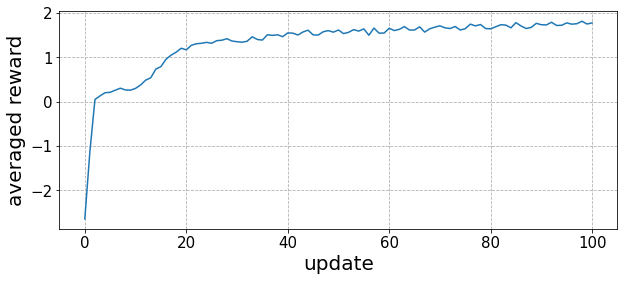

In [99]:
plt.figure(figsize=(10, 4))
plt.plot(vsoed.update_hist[:])
plt.xlabel('update', fontsize=20)
plt.ylabel('averaged reward', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(linestyle='--')

In [164]:
ret = vsoed.asses(1000, 0.5, return_all=True)

In [165]:
(averaged_reward, thetas, dcs_hist, ds_hist, ys_hist, xbs, xps_hist, rewards_hist, Gs_hist) = ret

In [102]:
try:
    for _ in range(100):
        dowel.logger.pop_prefix()
except:
    pass
dowel.logger.push_prefix('[SOURCE] ')
vsoed.train(**vsoed_train_params)

TypeError: train() got an unexpected keyword argument 'n_newtraj'

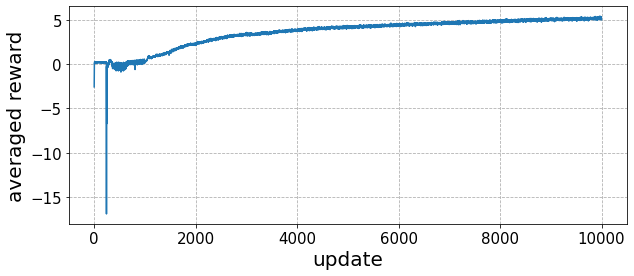

In [27]:
plt.figure(figsize=(10, 4))
plt.plot(vsoed.update_hist[:])
plt.xlabel('update', fontsize=20)
plt.ylabel('averaged reward', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(linestyle='--')

In [31]:
set_random_seed(42)
ret = vsoed.asses(2000, n_contrastive_sample=int(1e6), return_all=True)
averaged_reward = ret['averaged_reward']
params = ret['params']
ds_hist = ret['ds_hist']
ys_hist = ret['ys_hist']
rewards_hist = ret['rewards_hist']
averaged_reward

100%|██████████| 2000/2000 [00:20<00:00, 96.82it/s]


7.249750137329102

In [32]:
averaged_reward

7.249750137329102

In [30]:
rewards_hist

tensor([[ 0.4432,  0.7492,  3.0995,  ..., -0.1555,  0.2959,  0.0000],
        [ 0.4844,  0.0528, -0.7156,  ...,  0.4318,  1.1527,  0.0000],
        [ 0.6585,  1.0526,  0.7707,  ...,  0.3790,  3.0918,  0.0000],
        ...,
        [ 1.3779,  0.5406,  0.0820,  ...,  0.5592,  0.8644,  0.0000],
        [ 1.4406,  4.0038,  2.4328,  ...,  0.5097,  0.0841,  0.0000],
        [ 0.4491,  0.3017,  0.9296,  ...,  0.4463,  0.6337,  0.0000]],
       device='cuda:0')

In [206]:
post_approx.goal_weight

0

In [13]:
import joblib

In [14]:
joblib.dump(vsoed, folder + 'itr_0.pkl')

TypeError: cannot pickle 'module' object

In [9]:
vsoed.nkld_rw_f

<function vsOED.vsoed.VSOED.__init__.<locals>.nkld_rw_f(*args, **kws)>

In [51]:
torch.tensor(())

tensor([])

In [36]:
{'a': 1}.update({'b': 5})

In [ ]:
dict().update